In this notebook, I start with exploring the card transaction data and then clean it by identifying exclusion, removing outliers, and filling in missing values.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
start_time = pd.datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [ ]:
data = pd.read_excel('/content/drive/My Drive/5. USC/3. Spring 2020/DSO562 Fraud/Project/project03/card transactions.xlsx')

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


In [ ]:
data.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                   float64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [ ]:
data.rename(columns={'Merch description':'Merchdescription', 'Merch state':'Merchstate', 'Merch zip':'Merchzip'}, inplace=True)

## Data Exploration

I first check the number of null values, unique values, and 0's for all the fields

In [ ]:
data.isna().sum()

Recnum                 0
Cardnum                0
Date                   0
Merchnum            3375
Merchdescription       0
Merchstate          1195
Merchzip            4656
Transtype              0
Amount                 0
Fraud                  0
dtype: int64

In [ ]:
(data[["Cardnum", "Merchzip", 'Amount']] == 0).sum()

Cardnum     0
Merchzip    0
Amount      0
dtype: int64

In [ ]:
(data['Merchnum']=='0').sum()

231

I replace the 0's in the Merchnum field with NaN.

In [ ]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})

In [ ]:
data.nunique()

Recnum              96753
Cardnum              1645
Date                  365
Merchnum            13090
Merchdescription    13126
Merchstate            227
Merchzip             4567
Transtype               4
Amount              34909
Fraud                   2
dtype: int64

### Cardnum
Credit card number

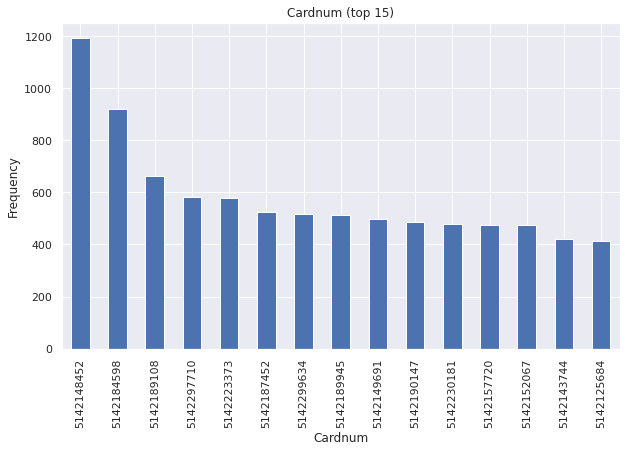

In [ ]:
sns.set()
plt.figure(figsize=(10,6))
data['Cardnum'].value_counts().head(15).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Cardnum')
plt.title('Cardnum (top 15)')
plt.show()

### Date
Date of each credit card transaction

In [ ]:
print(data.Date.min(), data.Date.max())

2010-01-01 00:00:00 2010-12-31 00:00:00


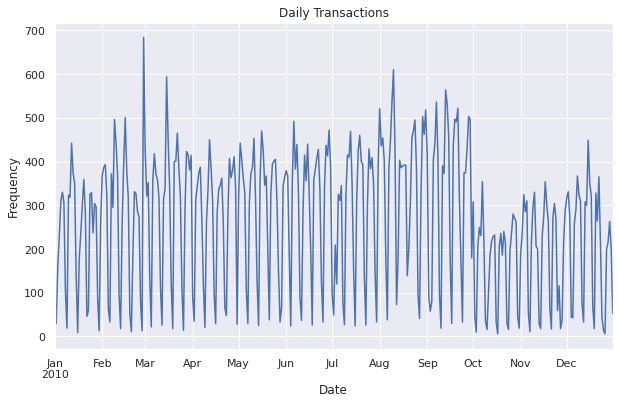

In [ ]:
plt.figure(figsize=(10,6))
data.set_index('Date').resample(timedelta(days=1)).Recnum.count().plot()
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.title('Daily Transactions')
plt.show()

The daily transactions graph below indicates that there is a natural weekly seasonality (weekdays vs weekend).

In [ ]:
weekly_count = data.set_index('Date').resample(timedelta(days=7)).Recnum.count()

In [ ]:
weekly_count.tail()

Date
2010-12-03    1602
2010-12-10    1828
2010-12-17    1582
2010-12-24     941
2010-12-31      53
Freq: 7D, Name: Recnum, dtype: int64

I replace the frequency in the week of 2010-12-31 with the frequency in the week of 2010-12-24 for the weekly transactions graph since the week of 2010-12-31 is connected to the next year.

In [ ]:
weekly_count['2010-12-31'] = weekly_count['2010-12-24']

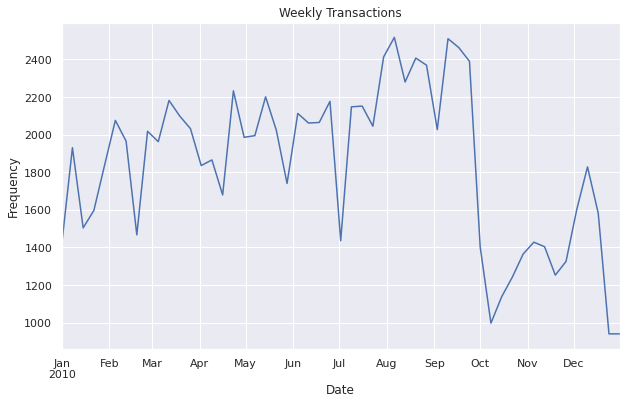

In [ ]:
plt.figure(figsize=(10,6))
weekly_count.plot()
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.title('Weekly Transactions')
plt.show()

In [ ]:
monthly_count = data.set_index('Date').resample(timedelta(days=30)).Recnum.count()

In [ ]:
monthly_count.tail()

Date
2010-08-29    10199
2010-09-28     5690
2010-10-28     5836
2010-11-27     6285
2010-12-27      931
Freq: 30D, Name: Recnum, dtype: int64

I replace the frequency in the month of 2010-12-27 with the frequency in the month of 2010-11-27 for the monthly transactions graph since the month of 2010-12-27 is connected to the next year.

In [ ]:
monthly_count['2010-12-27'] = monthly_count['2010-11-27']

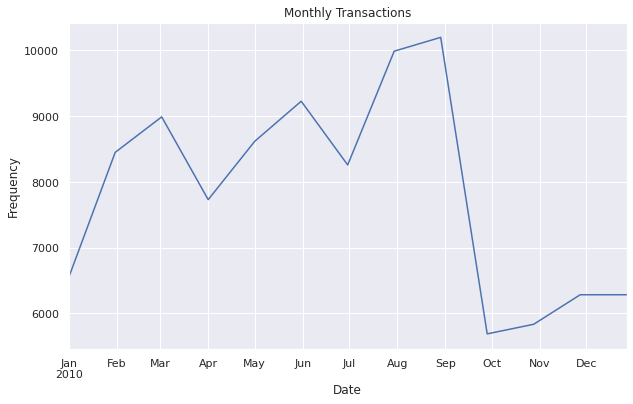

In [ ]:
plt.figure(figsize=(10,6))
monthly_count.plot()
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.title('Monthly Transactions')
plt.show()

The monthly transactions graph below suggests that there is an annual seasonality with a sharp decrease in October due to the fiscal year cycle.

### Merchnum
Unique number assigned to each merchant

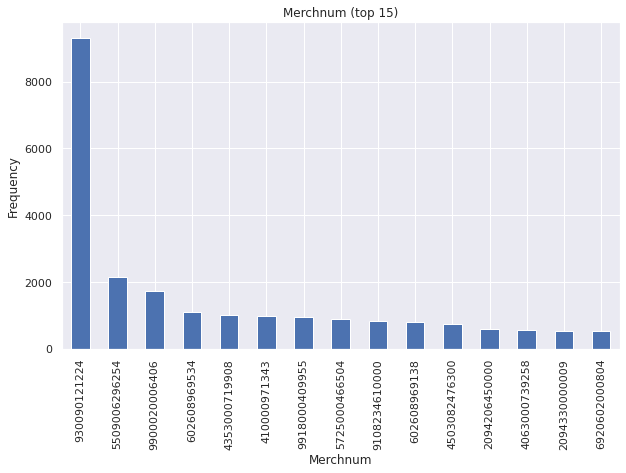

In [ ]:
plt.figure(figsize=(10,6))
data['Merchnum'].value_counts().head(15).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Merchnum')
plt.title('Merchnum (top 15)')
plt.show()

### Merchdescription
Description of each merchant

In [ ]:
data['Merchdescription'].value_counts().head(20)

GSA-FSS-ADV                 1688
SIGMA-ALDRICH               1635
STAPLES #941                1174
FISHER SCI ATL              1093
MWI*MICRO WAREHOUSE          958
CDW*GOVERNMENT INC           872
DELL MARKETING L.P.          816
FISHER SCI CHI               783
AMAZON.COM  *SUPERSTOR       750
OFFICE DEPOT #1082           748
VWR SCIENTIFIC PROD VCTS     688
PC *PC CONNECTION            570
C & C PRODUCT SERVICES       558
BUY.COM                      481
FISHER SCI HUS               442
GSA/CUST SUPPLY CTR 97       435
LAB SAFETY SUPPLY, INC       431
PROFESS OFC ENTERPRISES      421
FRANKLIN COVEY COMPANY       418
STAPLES NATIONAL #471        417
Name: Merchdescription, dtype: int64

### Merchstate
Abbreviation of the state where each merchant is located

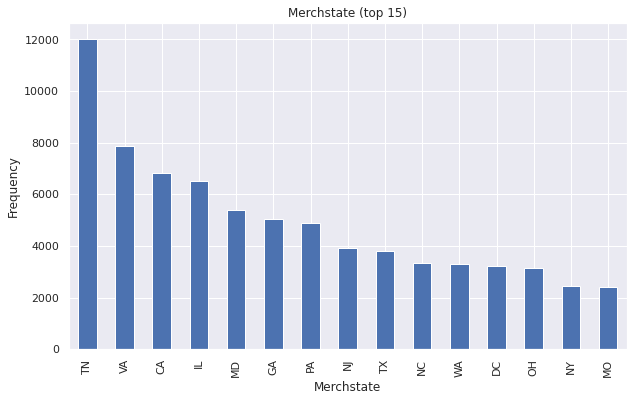

In [ ]:
plt.figure(figsize=(10,6))
data['Merchstate'].value_counts().head(15).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Merchstate')
plt.title('Merchstate (top 15)')
plt.show()

### Merchzip
5 digit zip code of each merchant

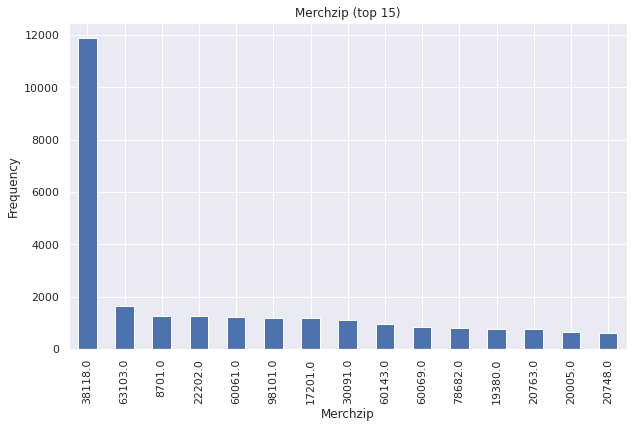

In [ ]:
plt.figure(figsize=(10,6))
data['Merchzip'].value_counts().head(15).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Merchzip')
plt.title('Merchzip (top 15)')
plt.show()

### Transtype
Type of each transaction (there are 4 types of transactions but we will only focus on Purchase for this project).

In [ ]:
data['Transtype'].value_counts()

P    96398
A      181
D      173
Y        1
Name: Transtype, dtype: int64

### Amount
The dollar amount of each credit card transaction

In [ ]:
data.Amount.describe()

count    9.675300e+04
mean     4.278857e+02
std      1.000614e+04
min      1.000000e-02
25%      3.348000e+01
50%      1.379800e+02
75%      4.282000e+02
max      3.102046e+06
Name: Amount, dtype: float64

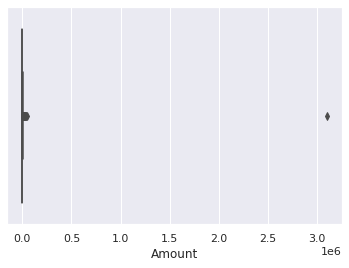

In [ ]:
sns.boxplot(data.Amount)

From the boxplot, I found one outlier which I will remove in the data cleaning stage.

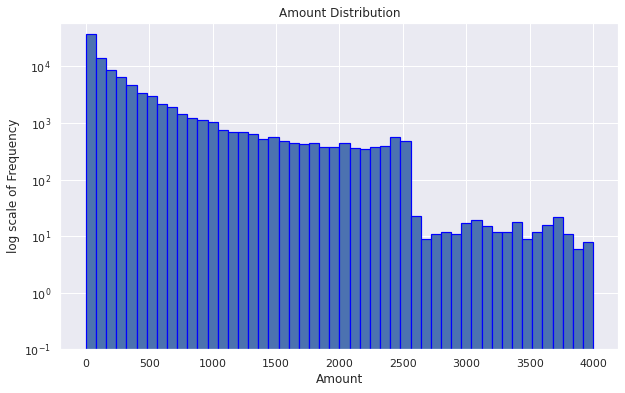

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(data['Amount'], bins=50, range=[0,4000], edgecolor='blue', linewidth=1.2)
plt.yscale('log')
plt.ylim(bottom = .1)
plt.xlabel('Amount')
plt.title('Amount Distribution')
plt.ylabel('log scale of Frequency')
plt.show()

### Fraud
Target label indicating whether a transaction is a fraud or not

In [ ]:
data['Fraud'].value_counts()

0    95694
1     1059
Name: Fraud, dtype: int64

In [ ]:
print(f'Overall fraud rate is {round(len(data[data.Fraud==1])/len(data),4)*100}%')

Overall fraud rate is 1.09%


## Data Cleaning

### Identify exclusion and bad records

I first filter the dataset by ‘P’ type transaction only to analyze normal transactions and exclude a single outlier in the Amount field.

In [ ]:
data = data[data['Transtype'] == 'P']
data = data[data.Amount<=1000000].copy()

In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


### Fill in missing values

In [ ]:
data.isna().sum()

Recnum                 0
Cardnum                0
Date                   0
Merchnum            3251
Merchdescription       0
Merchstate          1020
Merchzip            4300
Transtype              0
Amount                 0
Fraud                  0
dtype: int64

In [ ]:
col = ["Cardnum", "Merchnum", "Merchstate", "Merchzip"]
for c in col:
    data[c] = data[c].astype(str)

- Merchnum: I group by Merchdescription and then by Cardnum to replace the null values with the most frequent values. For the rest of the null values, I replace them with Recnum.
- Merchstate: I group by Merchnum to replace the null values with the most frequent values. For the rest of the null values, I replace them with Recnum.
- Merchzip: I group by Merchnum to replace the null values with the most frequent values. For the rest of the null values, I replace them with Recnum.

In [ ]:
def most_frequent(df, col):
    idx = df.reset_index()['count'].idxmax()
    return df[col].iloc[idx]

In [ ]:
def replace_null(df, colname, linkingnames, alter=None):   
    for linkingname in linkingnames:
        initialnull = len(df[df[colname]=='nan'])
        temp = df.groupby([linkingname, colname]).size().reset_index().rename(columns={0:'count'})
        temp = temp.groupby(linkingname).apply(most_frequent, col=colname)
        df['mode_'+colname+'_groupby_'+linkingname] = df[linkingname].map(temp)
        df[colname] = np.where(df[colname]=='nan', df['mode_'+colname+'_groupby_'+linkingname], df[colname])
        endnull = len(df[df[colname]=='nan'])
        print(f'using {linkingname} - initial: {initialnull} null values, replaced: {initialnull-endnull} null values, remaining: {endnull} null values')
        df.drop(columns='mode_'+colname+'_groupby_'+linkingname, inplace=True)
    
    if (df[colname]=='nan').sum()>0 and alter:
        df[colname] = np.where(df[colname]=='nan',df[alter],df[colname])
        print(f'using alter_{alter} - initial: {endnull} null values, replaced: {endnull} null values, remaining: 0 null values')
    
    return df

In [ ]:
data = replace_null(data, 'Merchnum', ['Merchdescription','Cardnum'], 'Recnum')

using Merchdescription - initial: 3251 null values, replaced: 424 null values, remaining: 2827 null values
using Cardnum - initial: 2827 null values, replaced: 2102 null values, remaining: 725 null values
using alter_Recnum - initial: 725 null values, replaced: 725 null values, remaining: 0 null values


In [ ]:
data = replace_null(data, 'Merchstate', ['Merchnum'], 'Recnum')

using Merchnum - initial: 1020 null values, replaced: 623 null values, remaining: 397 null values
using alter_Recnum - initial: 397 null values, replaced: 397 null values, remaining: 0 null values


In [ ]:
data = replace_null(data, 'Merchzip', ['Merchnum'], 'Recnum')

using Merchnum - initial: 4300 null values, replaced: 1635 null values, remaining: 2665 null values
using alter_Recnum - initial: 2665 null values, replaced: 2665 null values, remaining: 0 null values


In [ ]:
data

,Recnum,Cardnum,Date,Merchnum,Merchdescription,Merchstate,Merchzip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


In [ ]:
data.to_csv('/content/drive/My Drive/5. USC/3. Spring 2020/DSO562 Fraud/Project/project03/card transactions_cleaned.csv')

In [ ]:
stop_time = pd.datetime.now()
print('duration: ', stop_time - start_time)

duration:  0:00:55.161631


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
